In [1]:
from pathlib import Path
from PIL import Image
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

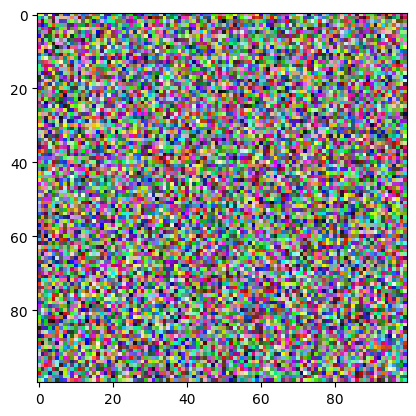

In [2]:
test_data = np.random.beta(1, 1, size=(100, 100, 3))

plt.imshow(test_data)

In [ ]:
from PIL import Image
from IPython.display import display

def display_image(image_path):
    img = Image.open(image_path)
    print(f"The image size is: {img.size}")
    display(img)
    return img

img = display_image('datasets/bee_1.jpg')

In [ ]:
def transform_and_display_image(img):
    img_cropped = img.crop((25, 25, 75, 75))
    img_rotated = img.rotate(45, expand=True)
    img_flipped = img.transpose(Image.FLIP_LEFT_RIGHT)

    display(img_cropped)
    display(img_rotated)
    display(img_flipped)

transform_and_display_image(img)

In [ ]:
def display_image_channels(img):
    img_data = np.array(img)
    print(f"Our NumPy array has the shape: {img_data.shape}")

    plt.imshow(img_data)
    plt.show()

    colors = ['Reds_r', 'Greens_r', 'Blues_r']
    for i, color in enumerate(colors):
        plt.imshow(img_data[:, :, i], cmap=plt.get_cmap(color))
        plt.show()

display_image_channels(img)

In [ ]:
import pandas as pd

def plot_kde(channel, color):
    data = channel.flatten()
    pd.Series(data).plot.density(c=color)

def plot_rgb(img_data):
    channels = ['r', 'g', 'b']
    for i, color in enumerate(channels):
        plot_kde(img_data[:, :, i], color)
    plt.show()

plot_rgb(np.array(img))

In [ ]:
def convert_and_plot_grayscale(img):
    img_bw = img.convert("L")
    img_bw_arr = np.array(img_bw)
    print(f"Our NumPy array has the shape: {img_bw_arr.shape}")

    plt.imshow(img_bw_arr, cmap=plt.cm.gray)
    plt.show()

    plot_kde(img_bw_arr, 'k')

honey = display_image('datasets/bee_12.jpg')
bumble = display_image('datasets/bee_3.jpg')

plot_rgb(np.array(honey))
plot_rgb(np.array(bumble))

convert_and_plot_grayscale(honey)

In [ ]:
import pandas as pd

labels = pd.read_csv("datasets/labels.csv", index_col=0)
display(labels.head())

In [ ]:
import os

def get_image(row_id, root="datasets/"):
    file_path = os.path.join(root, f"{row_id}.jpg")
    return np.array(Image.open(file_path))

def create_features(img):
    from skimage.feature import hog
    from skimage.color import rgb2grey

    color_features = img.flatten()
    grey_image = rgb2grey(img)
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    return np.hstack([color_features, hog_features])

def create_feature_matrix(label_dataframe):
    features_list = [create_features(get_image(img_id)) for img_id in label_dataframe.index]
    return np.array(features_list)

In [ ]:
import matplotlib.pyplot as plt

apis_row = labels[labels.genus == 0.0].index[5]
bombus_row = labels[labels.genus == 1.0].index[5]

plt.imshow(get_image(apis_row))
plt.show()

plt.imshow(get_image(bombus_row))
plt.show()

bombus = get_image(bombus_row)
grey_bombus = rgb2grey(bombus)

hog_features, hog_image = hog(grey_bombus, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))

plt.imshow(hog_image, cmap=plt.cm.gray)
plt.show()

bombus_features = create_features(bombus)
print(f"Bombus features shape: {bombus_features.shape}")

feature_matrix = create_feature_matrix(labels)
print(f"Feature matrix shape: {feature_matrix.shape}")

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
bees_stand = scaler.fit_transform(feature_matrix)

pca = PCA(n_components=500)
bees_pca = pca.fit_transform(bees_stand)

print(f"PCA matrix shape: {bees_pca.shape}")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(bees_pca, labels.genus.values, test_size=0.3, random_state=1234123)

svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# ROC curve and AUC
y_proba = svm.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()